In [1]:
#import libraries
import tables
from tables import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash

In [2]:
#open/read file
file = tables.open_file("Data/training/dl1v06_reorganized_gamma_20deg_180deg_run4___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5","r")

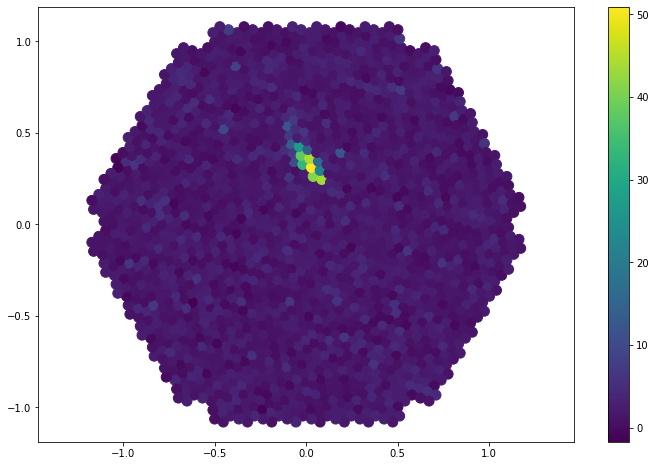

In [3]:
#visualize images from the telescope
img = file.root.dl1.event.telescope.images.LST_LSTCam.col("image")
px_row = file.root.instrument.telescope.camera.LSTCam.col("pix_x")
px_col = file.root.instrument.telescope.camera.LSTCam.col("pix_y")

plt.figure(figsize=(12,8))
plt.scatter(px_row,px_col,c=img[3],s=100)
plt.colorbar()
plt.axis("equal")
plt.show()

In [4]:
# retrieve most interesting events
tab_good_event = [event for event in img if event.std()>30]
print(len(tab_good_event))

37


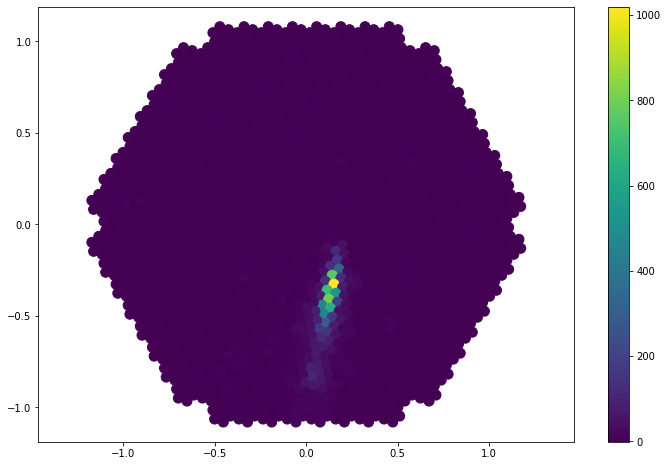

In [5]:
htable = np.fromfile("injunction_table_lst.pny", offset=8, dtype=np.uint16)
matrix = np.zeros(55*55)
matrix[htable] = tab_good_event[0]
res = matrix.reshape(55,55)

plt.figure(figsize=(12,8))
plt.scatter(px_row,px_col,c=tab_good_event[0],s=100)
plt.colorbar()
plt.axis("equal")
plt.imsave("imgrun4.png",res)
plt.show()

In [6]:
#compute image hash with perceptual hash
hash = imagehash.phash(Image.open("imgrun4.png"))

In [7]:
#retrieving some parameters of the simulated images
E = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_energy")
h = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_h_first_int")
x = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_core_x")
y = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_core_y")
Imax = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("mc_x_max")
eventId = file.root.dl1.event.telescope.parameters.LST_LSTCam.col("event_id")

In [8]:
#retrieving parameters of the telescope
pos_x = file.root.instrument.subarray.layout.col("pos_x")
pos_y = file.root.instrument.subarray.layout.col("pos_y")

In [9]:
#compute alpha angle at position j
def angle(j,x,y,pos_x,pos_y):
    alpha = []
    for i in range(x.size):
        tmp = np.math.atan2(y[i]-pos_y[j],x[i]-pos_x[j]) *  180 / np.pi
        alpha.append(tmp)

    return alpha

alpha = angle(0,x,y,pos_x,pos_y)

In [10]:
# Applying SVD
U, S, VT = np.linalg.svd(res,full_matrices=False,# It's not necessary to compute the full matrix of U or V
      compute_uv=True) # Deterministic SVD

S = np.diag(S) #singular value matrix
sv = []
for i in range(55):
      sv.append(S[i][i])
#sv

In [11]:
#compute impact parameter
def cip(j,x,y,pos_x,pos_y):
    impact = []
    for i in range(x.size):
        dist2 = np.square(x[i]-pos_x[j]) + np.square(y[i]-pos_y[j])
        impact.append(np.sqrt(dist2))

    return impact

In [12]:
ro = cip(0,x,y,pos_x,pos_y) #impact parameter at position 0

In [13]:
#creating tables for datasets
class Mc_shower(IsDescription):
    type = StringCol(16)
    idevent = UInt64Col()
    energy = Float32Col()
    hfirstint = Float32Col()
    Imax = Float32Col()
    impact = Float32Col()
    x = Float32Col()
    y = Float32Col()
    hash = StringCol(64)
    sv = Float64Col()
    alpha = Float64Col()

h5file = open_file("sim_img.h5",mode ="w", title="Simulated image file")
group = h5file.create_group("/",'Shower','Shower Info')
table = h5file.create_table(group,"readout",Mc_shower,"mc_shower table")

In [15]:
#now let's fill the table with its values
gerbe = table.row #write data rows into the table

for i in range(len(sv)):
    gerbe['type'] = f'Event: {i:6d}'
    gerbe['idevent'] = eventId[i]
    gerbe['energy'] = E[i]
    gerbe['hfirstint'] = h[i]
    gerbe['x'] = x[i]
    gerbe['y'] = y[i]
    gerbe['Imax'] = Imax[i]
    gerbe['impact'] = ro[i]
    gerbe['hash'] = hash
    gerbe['sv'] = sv[i]
    gerbe['alpha'] = alpha[i]
    #insert a new gerbe record

    gerbe.append()

table.flush()
table = h5file.root.Shower.readout

hfi = [x['hfirstint'] for x in table.iterrows()]
#hfi

In [16]:
h5file.close()